# MSc in Data Science and Big Data 
## Master Thesis
## Innovation & Entrepreneurship Business School
### Guillermo Altesor 


**If your run this Notebook in Google Colab you must run it between 3 and 5 times untill runs correctly (errors with Google Colab that are not shown in local - VS Code)**

---

In this Notebook we will splore different Collaborative Filtering model-based Recommender Systems and a Hybrid Recommender System


## Loading the data

In [1]:
import pandas as pd
import numpy as np

cdf = pd.read_csv("Cured_Att_CI_TA.csv", index_col=False)

# We need to set these dtype again

cdf['r_Date'] = pd.to_datetime(cdf['r_Date']) 
#df['u_Id'] = df.u_Id.astype('category')
#df['u_Country'] = df.u_Country.astype('category')
#df['u_Trip_type'] = df.u_Trip_type.astype('category')
#df['Item'] = df.Item.astype('category')
#df['i_Island'] = df.i_Island.astype('category')
##df['i_Type'] = df.i_Type.astype('category')

cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9860 entries, 0 to 9859
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   u_Id             9860 non-null   int64         
 1   u_Country        9860 non-null   object        
 2   u_Contributions  9860 non-null   int64         
 3   u_Trip_type      9860 non-null   object        
 4   Review           9860 non-null   object        
 5   r_Rating         9860 non-null   float64       
 6   r_Date           9860 non-null   datetime64[ns]
 7   r_Helpful        9860 non-null   int64         
 8   i_Id             9860 non-null   int64         
 9   Item             9860 non-null   object        
 10  i_Island         9860 non-null   object        
 11  i_Rating         9860 non-null   float64       
 12  i_Reviews        9860 non-null   int64         
 13  i_Excellent      9860 non-null   int64         
 14  i_Very_good      9860 non-null   int64  

In [2]:
cdf.head()

,u_Id,u_Country,u_Contributions,u_Trip_type,Review,r_Rating,r_Date,r_Helpful,i_Id,Item,i_Island,i_Rating,i_Reviews,i_Excellent,i_Very_good,i_Average,i_Poor,i_Terrible,i_Type
0,717354021,United Kingdom,7,Unknown,"Worth the trip, cable car needs minimum 90 min...",4.0,2022-07-26,1,717354021,Volcan El Teide,Tenerife,4.5,13470,9917,2729,552,151,121,Volcanos
1,946286476,United Kingdom,7,Unknown,Must see of Tenerife - A must see site on Tene...,5.0,2022-07-25,0,717354021,Volcan El Teide,Tenerife,4.5,13470,9917,2729,552,151,121,Volcanos
2,784077896,United Kingdom,44,Family,A must visit place in tenerife. - Absolutely a...,5.0,2022-07-17,0,717354021,Volcan El Teide,Tenerife,4.5,13470,9917,2729,552,151,121,Volcanos
3,491263,Unknown,8,Family,Hike to the summit. - A drive up to El Tiede f...,5.0,2022-07-17,0,717354021,Volcan El Teide,Tenerife,4.5,13470,9917,2729,552,151,121,Volcanos
4,550290313,United Kingdom,52,Couples,Spectacular - It's number one for a reason. O...,5.0,2022-07-17,1,717354021,Volcan El Teide,Tenerife,4.5,13470,9917,2729,552,151,121,Volcanos


**We must create 3 different DataFrames: User_df, Item_df and Rating_df.**

## user_df

In [3]:
user_df = cdf[['u_Id', 'u_Country', 'u_Contributions']]
user_df = user_df.drop_duplicates(subset=['u_Id'])

user_df.head(5)


,u_Id,u_Country,u_Contributions
0,717354021,United Kingdom,7
1,946286476,United Kingdom,7
2,784077896,United Kingdom,44
3,491263,Unknown,8
4,550290313,United Kingdom,52


In [4]:
user_df.nunique()

u_Id               6164
u_Country            73
u_Contributions     722
dtype: int64

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 9858
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   u_Id             6164 non-null   int64 
 1   u_Country        6164 non-null   object
 2   u_Contributions  6164 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 192.6+ KB


In [6]:
user_grouped = cdf.groupby(['u_Country','u_Trip_type']).size()
g1 = pd.DataFrame(data=user_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100))
g1.head(10)


0
u_Country u_Trip_type            
Australia Couples       33.333333
          Family        33.333333
          Solo           8.333333
          Unknown       25.000000
Austria   Couples        7.142857
          Family        21.428571
          Solo          14.285714
          Unknown       57.142857
Bahrain   Family       100.000000
Barbados  Couples      100.000000

**We will create Age and Gender of our Users in order to have more accurate data for the processing. We will fallow proportions gathered from the ISTAC (Canarian Institute of Statistics)**
http://www.gobiernodecanarias.org/istac/jaxi-istac/tabla.do

In [7]:
import random

user_df['u_Gender'] = random.choices(
    population=['M', 'F'],
    weights=[0.51, 0.49],
    k=6164)

user_df['u_AgeGroup'] = random.choices(
    population=['Teenager', 'Young', 'Midlife', 'Elderly'],
    weights=[0.13, 0.39, 0.3, 0.18],
    k=6164)


In [8]:
user_df.sample(10)

,u_Id,u_Country,u_Contributions,u_Gender,u_AgeGroup
3870,583728296,United Kingdom,1,M,Teenager
7392,151878293,Unknown,4,F,Young
970,795128998,Unknown,3,F,Midlife
7888,578601100,Sri Lanka,5,M,Midlife
687,54381598,United Kingdom,14,F,Midlife
1946,397531180,United Kingdom,66,F,Young
1013,538738504,United Kingdom,12,M,Teenager
352,235169068,United Kingdom,298,F,Midlife
4889,411586469,United Kingdom,128,M,Elderly
22,830873852,United Arab Emirates,1,F,Young


In [9]:
user_df = user_df[['u_Id', 'u_Country', 'u_Contributions', 'u_Gender', 'u_AgeGroup', 'u_AgeGroup']]
user_df.columns = ['u_Id', 'u_Country', 'u_Contributions', 'u_Gender', 'u_Age', 'u_AgeGroup']

replacements = {
  r'Teenager': '18',
  r'Young': '30',
  r'Midlife': '45',
  r'Elderly': '65'}

user_df['u_Age'] = user_df.u_Age.replace(replacements, regex=True)

user_df['u_Age'] = pd.to_numeric(user_df['u_Age'], errors='coerce').fillna(0).astype(int)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
user_df.sample()

,u_Id,u_Country,u_Contributions,u_Gender,u_Age,u_AgeGroup
8071,378945600,United States,244,F,18,Teenager


In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 9858
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   u_Id             6164 non-null   int64 
 1   u_Country        6164 non-null   object
 2   u_Contributions  6164 non-null   int64 
 3   u_Gender         6164 non-null   object
 4   u_Age            6164 non-null   int64 
 5   u_AgeGroup       6164 non-null   object
dtypes: int64(3), object(3)
memory usage: 337.1+ KB


## Item_df

In [12]:
item_df = cdf[['i_Id', 'Item', 'i_Type', 'i_Island']]

item_df = item_df.drop_duplicates()

item_df.head()

,i_Id,Item,i_Type,i_Island
0,717354021,Volcan El Teide,Volcanos,Tenerife
173,946286476,Timanfaya National Park,"National Parks, Geologic Formations",Lanzarote
445,784077896,Cocodrilo Park Gran Canaria,"Parks, Gardens",Gran Canaria
474,491263,Finca Canarias Aloe Vera,Farms,Fuerteventura
480,550290313,Siam Park,"Amusement & Theme Parks, Water Parks",Tenerife


In [13]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 9858
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   i_Id      629 non-null    int64 
 1   Item      629 non-null    object
 2   i_Type    629 non-null    object
 3   i_Island  629 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.6+ KB


In [14]:
# Get a list of the issues
issues = sorted(set(", ".join(item_df.i_Type).split(", ")))

# Fill columns with 0's and 1's
for issue in issues:
    item_df[issue] = item_df.i_Type.str.contains(issue).astype(int)

# Dropping i_Type column
item_df.drop('i_Type', inplace=True, axis=1)
 

In [15]:
item_df.head(5)

,i_Id,Item,i_Island,Amusement & Theme Parks,Ancient Ruins,Aquariums,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,...,Theaters,Theatre & Performances,Trams,Valleys,Visitor Centers,Volcanos,Water Parks,Waterfalls,Yoga & Pilates,Zoos
0,717354021,Volcan El Teide,Tenerife,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
173,946286476,Timanfaya National Park,Lanzarote,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445,784077896,Cocodrilo Park Gran Canaria,Gran Canaria,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
474,491263,Finca Canarias Aloe Vera,Fuerteventura,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
480,550290313,Siam Park,Tenerife,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
def check_nan_percent(item_df):
    columns_null_count = cdf.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/cdf.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

In [17]:
check_nan_percent(item_df)

,null_percent,total_null


In [18]:
pd.set_option('display.max_rows', None)

In [19]:
pd.set_option('display.max_columns', None)

## rating_df

In [20]:
rating_df = cdf[['u_Id', 'i_Id', 'r_Rating', 'r_Date']]
rating_df.sample(5)

,u_Id,i_Id,r_Rating,r_Date
4222,647208577,621080892,5.0,2020-02-10
3276,691323623,550260202,3.0,2020-01-03
8593,233847355,854768591,4.0,2022-01-06
992,765035988,550290313,5.0,2021-10-30
5648,95655402,705144579,5.0,2022-06-26


In [21]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9860 entries, 0 to 9859
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   u_Id      9860 non-null   int64         
 1   i_Id      9860 non-null   int64         
 2   r_Rating  9860 non-null   float64       
 3   r_Date    9860 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 308.2 KB


## 3 DF

In [22]:
user_df.head(5)

,u_Id,u_Country,u_Contributions,u_Gender,u_Age,u_AgeGroup
0,717354021,United Kingdom,7,M,45,Midlife
1,946286476,United Kingdom,7,M,65,Elderly
2,784077896,United Kingdom,44,M,45,Midlife
3,491263,Unknown,8,F,65,Elderly
4,550290313,United Kingdom,52,M,30,Young


In [23]:
item_df.head(5)

,i_Id,Item,i_Island,Amusement & Theme Parks,Ancient Ruins,Aquariums,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Beaches,Bodies of Water,Breweries,Cabarets,Casinos,Castles,Caverns & Caves,Children's Museums,Churches & Cathedrals,Civic Centres,Convention Centers,Department Stores,Dinner Theaters,Distilleries,Farmers Markets,Farms,Ferries,Flea & Street Markets,Forests,Fountains,Game & Entertainment Centers,Gardens,Geologic Formations,Government Buildings,Hiking Trails,Historic Sites,Historic Walking Areas,History Museums,Horseback Riding Tours,Hot Springs & Geysers,Islands,Libraries,Lighthouses,Lookouts,Marinas,Military Bases & Facilities,Military Museums,Miniature Golf,Monuments & Statues,Mountains,Movie Theaters,National Parks,Natural History Museums,Nature & Wildlife Areas,Neighborhoods,Observatories & Planetariums,Parks,Piers & Boardwalks,Points of Interest & Landmarks,Religious Sites,Scenic Walking Areas,Science Museums,Shopping Malls,Speciality Museums,Sports Camps & Clinics,Sports Complexes,State Parks,Theaters,Theatre & Performances,Trams,Valleys,Visitor Centers,Volcanos,Water Parks,Waterfalls,Yoga & Pilates,Zoos
0,717354021,Volcan El Teide,Tenerife,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
173,946286476,Timanfaya National Park,Lanzarote,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
445,784077896,Cocodrilo Park Gran Canaria,Gran Canaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
474,491263,Finca Canarias Aloe Vera,Fuerteventura,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,550290313,Siam Park,Tenerife,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
rating_df.head(5)

,u_Id,i_Id,r_Rating,r_Date
0,717354021,717354021,4.0,2022-07-26
1,946286476,717354021,5.0,2022-07-25
2,784077896,717354021,5.0,2022-07-17
3,491263,717354021,5.0,2022-07-17
4,550290313,717354021,5.0,2022-07-17


In [25]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 9858
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   u_Id             6164 non-null   int64 
 1   u_Country        6164 non-null   object
 2   u_Contributions  6164 non-null   int64 
 3   u_Gender         6164 non-null   object
 4   u_Age            6164 non-null   int64 
 5   u_AgeGroup       6164 non-null   object
dtypes: int64(3), object(3)
memory usage: 337.1+ KB


In [26]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9860 entries, 0 to 9859
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   u_Id      9860 non-null   int64         
 1   i_Id      9860 non-null   int64         
 2   r_Rating  9860 non-null   float64       
 3   r_Date    9860 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 308.2 KB


In [27]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 9858
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   i_Id                            629 non-null    int64 
 1   Item                            629 non-null    object
 2   i_Island                        629 non-null    object
 3   Amusement & Theme Parks         629 non-null    int64 
 4   Ancient Ruins                   629 non-null    int64 
 5   Aquariums                       629 non-null    int64 
 6   Architectural Buildings         629 non-null    int64 
 7   Arenas & Stadiums               629 non-null    int64 
 8   Art Galleries                   629 non-null    int64 
 9   Art Museums                     629 non-null    int64 
 10  Beaches                         629 non-null    int64 
 11  Bodies of Water                 629 non-null    int64 
 12  Breweries                       629 non-null    i

In [28]:
def check_nan_percent(df):
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

In [29]:
check_nan_percent(user_df)

,null_percent,total_null


In [30]:
check_nan_percent(item_df)

,null_percent,total_null


In [31]:
check_nan_percent(rating_df)

,null_percent,total_null


## Finding Insights from o data

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [33]:
#We generate joins of our df to work with them as one.
rating_user_df = rating_df.join(other=user_df, how='inner', on='u_Id', lsuffix='_R')
rating_user_item_df = rating_user_df.join(other=item_df, how='inner', on='i_Id', rsuffix='_M')
rating_item_df = rating_df.join(other=item_df, how='inner', on='i_Id', rsuffix='_M')

**Most comun Attractions**

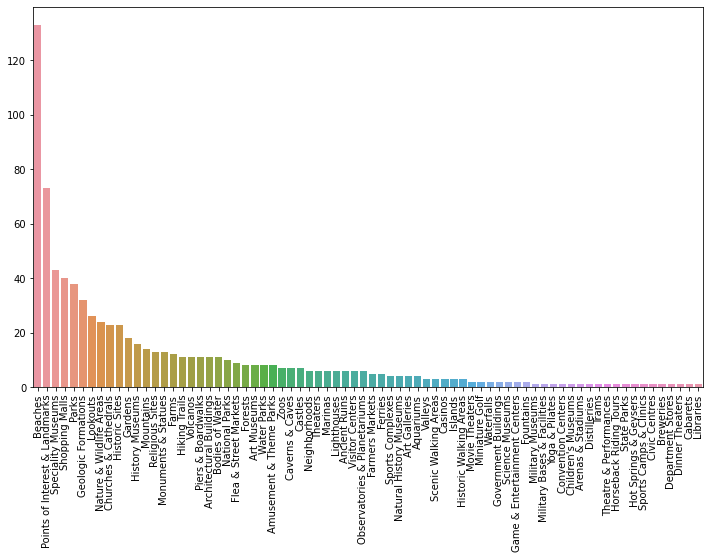

In [34]:
att_types = ['Amusement & Theme Parks', 'Ancient Ruins', 'Aquariums',
       'Architectural Buildings', 'Arenas & Stadiums', 'Art Galleries',
       'Art Museums', 'Beaches', 'Bodies of Water', 'Breweries', 'Cabarets',
       'Casinos', 'Castles', 'Caverns & Caves', "Children's Museums",
       'Churches & Cathedrals', 'Civic Centres', 'Convention Centers',
       'Department Stores', 'Dinner Theaters', 'Distilleries',
       'Farmers Markets', 'Farms', 'Ferries', 'Flea & Street Markets',
       'Forests', 'Fountains', 'Game & Entertainment Centers', 'Gardens',
       'Geologic Formations', 'Government Buildings', 'Hiking Trails',
       'Historic Sites', 'Historic Walking Areas', 'History Museums',
       'Horseback Riding Tours', 'Hot Springs & Geysers', 'Islands',
       'Libraries', 'Lighthouses', 'Lookouts', 'Marinas',
       'Military Bases & Facilities', 'Military Museums', 'Miniature Golf',
       'Monuments & Statues', 'Mountains', 'Movie Theaters', 'National Parks',
       'Natural History Museums', 'Nature & Wildlife Areas', 'Neighborhoods',
       'Observatories & Planetariums', 'Parks', 'Piers & Boardwalks',
       'Points of Interest & Landmarks', 'Religious Sites',
       'Scenic Walking Areas', 'Science Museums', 'Shopping Malls',
       'Speciality Museums', 'Sports Camps & Clinics', 'Sports Complexes',
       'State Parks', 'Theaters', 'Theatre & Performances', 'Trams', 'Valleys',
       'Visitor Centers', 'Volcanos', 'Water Parks', 'Waterfalls',
       'Yoga & Pilates', 'Zoos']

plt.figure(figsize=(12,7))
genere_counts = item_df.loc[:,att_types].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=90);

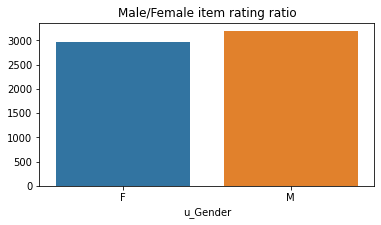

In [35]:
plt.figure(figsize=(6,3))
sns.barplot(x=user_df.groupby('u_Gender').size().index, y=user_df.groupby('u_Gender').size().values)
plt.title('Male/Female item rating ratio');

**Most comun Age Group**

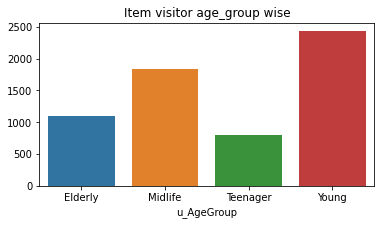

In [36]:
plt.figure(figsize=(6,3))
sns.barplot(x=user_df.groupby('u_AgeGroup').size().index, 
            y=user_df.groupby('u_AgeGroup').size().values, )
plt.title('Item visitor age_group wise');

**Most comun Trip Types**

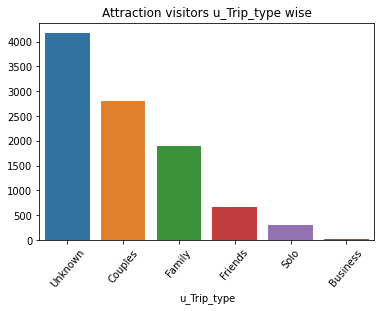

In [37]:
plt.figure(figsize=(6,4))
item_visitor_triptype = cdf.groupby('u_Trip_type').size().sort_values(ascending=False)
sns.barplot(x=item_visitor_triptype.index, y=item_visitor_triptype.values)
plt.title('Attraction visitors u_Trip_type wise')
plt.xticks(rotation=50);

**Most visited Attractions vs Most rated Attractions**

In [38]:
attractions = item_df[['Item', 'i_Id']]
df = pd.merge(rating_df, attractions, on='i_Id')
df.groupby('Item')['r_Rating'].count().sort_values(ascending=False).head(10)

Item
Siam Park                                              875
Loro Parque                                            388
Timanfaya National Park                                272
Rancho Texas Lanzarote Park                            213
Barranco del Infierno                                  203
Marina Rubicon                                         195
Volcan El Teide                                        173
Monkey Park                                            169
Reserva Natural Especial de Las Dunas de Maspalomas    146
Playa Blanca                                           138
Name: r_Rating, dtype: int64

In [39]:
df.groupby('Item')['r_Rating'].mean().sort_values(ascending=False).head(10)

Item
7 Palmas                                                      5.0
Ermita San Pedro de Alcantara                                 5.0
Playa del Matorral                                            5.0
Finca Los Castanos                                            5.0
Playa del Confital                                            5.0
Fundacion Cristino de Vera - Espacio Cultural CajaCanarias    5.0
Galaxia Cine6D                                                5.0
Casa De La Cultura De Firgas                                  5.0
Galeria ATC                                                   5.0
Green Eleven - “A Compás” Flamenco Show                       5.0
Name: r_Rating, dtype: float64

# Recommender System

We will first design a model based on neural networks and then one based on XGBoost, to obtain an expected rating for those cases in which the data is not available, and unify them. Neural networks work very well when the data faces some continuity, but when we are faced with discrete or categorical data, decision trees can show a significant advantage. That is why this combination is complementary and will help us to create a good recommendation for both users with little activity and a lot.

## Neural Network RS

In [40]:
df = rating_df

# Encrypt user identifiers
user_ids = df["u_Id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(rating_df["u_Id"].unique())

# We encode the identifiers of the items
item_ids = df["i_Id"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
num_items = len(rating_df["i_Id"].unique())

# And add them to the dataset
df["user"] = df["u_Id"].map(user2user_encoded)
df["item"] = df["i_Id"].map(item2item_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
# Range of values ​​for ratings
min_rating = 1.0
max_rating = 5.0

# Input data for our network
x = df[["user", "item"]].values

# We normalize the ratings between 0 and 1
y = df["r_Rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# We make the separation between training and validation
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)



In [42]:
rating_df.sample(5)

,u_Id,i_Id,r_Rating,r_Date,user,item
1144,793518491,550290313,2.0,2021-08-16,1118,4
5470,79784165,383564362,5.0,2020-08-10,311,108
8782,976937878,829724108,5.0,2020-02-28,4432,396
5064,464199688,83180453,4.0,2022-07-17,2519,93
7973,718568663,557356243,5.0,2022-04-18,29,279


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):
    """
    Clase que codifica un modelo tipo como red de recomendación
    """
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Size of our rendering models (embeding)
        self.num_users = num_users
        self.num_items = num_items
        
        # Representation of users
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        # Item Representation
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1) # Bias

    # Function that is called with an input type
    def call(self, inputs):
        # User
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Item
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        # Input vector for the network (user + item + bias)
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        x = dot_user_item + user_bias + item_bias

        # We apply a sigmoid function to evaluate the rating (0 to 1.0)
        return tf.nn.sigmoid(x)

With our neural structure raised, we simply have to instantiate the model indicating what the loss functions will be and the optimizer to use when we train the network.

We will select BinaryCrossEntropy as the function that will evaluate the goodness of our model; and Adam as the optimizer function in our exercise, but these parameters can always be varied taking into account the characteristics of our problem to be solved.

In [44]:
model = RecommenderNet(num_users, num_items)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

Having defined our model, it only remains to adjust it based on our data set.

In [45]:
batch_size = 64 # Number of samples per batch to be used in training
epochs = 10 # Iterations over the data set

# We proceed to train the model
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
139/139 [==============================] - 2s 6ms/step - loss: 0.6764 - val_loss: 0.6928
Epoch 2/10
139/139 [==============================] - 1s 4ms/step - loss: 0.4776 - val_loss: 0.6934
Epoch 3/10
139/139 [==============================] - 1s 5ms/step - loss: 0.4723 - val_loss: 0.6935
Epoch 4/10
139/139 [==============================] - 1s 5ms/step - loss: 0.4681 - val_loss: 0.6934
Epoch 5/10
139/139 [==============================] - 1s 4ms/step - loss: 0.4638 - val_loss: 0.6932
Epoch 6/10
139/139 [==============================] - 1s 5ms/step - loss: 0.4602 - val_loss: 0.6930
Epoch 7/10
139/139 [==============================] - 1s 5ms/step - loss: 0.4555 - val_loss: 0.6926
Epoch 8/10
139/139 [==============================] - 1s 4ms/step - loss: 0.4524 - val_loss: 0.6923
Epoch 9/10
139/139 [==============================] - 1s 4ms/step - loss: 0.4492 - val_loss: 0.6920
Epoch 10/10
139/139 [==============================] - 1s 5ms/step - loss: 0.4469 - val_loss: 0.6916

If all went well, we should see some convergence in error based on the number of epochs used.

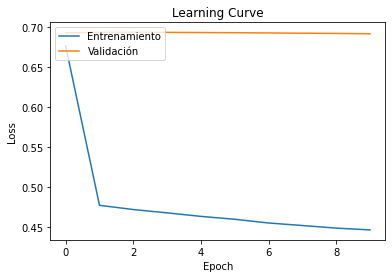

In [46]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Learning Curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()

With this model it is easy to be able to compose a function in charge of obtaining the unseen movies with the best score for a specific user.

In [47]:
def nn_recommender(user_id, num=10):
 
  # Item visitedd
  seen_items = rating_df[rating_df["u_Id"] == user_id]

  # No visited items
  not_seen = item_df[~item_df["i_Id"].isin(seen_items["i_Id"].values)]["i_Id"].tolist()
  not_seen = list(set(not_seen).intersection(set(item2item_encoded.keys())))
  not_seen = [[item2item_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data for the model
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]

  # Decode
  item_id = [item_encoded2item.get(not_seen[x][0]) for x in top_rated]

  return item_df[item_df["i_Id"].isin(item_id)]["Item"]

In [48]:
nn_recommender(946286476)

1355                                Playa de Las Canteras
1909    Reserva Natural Especial de Las Dunas de Maspa...
2743                                          Roque Nublo
3210                                         Montaña Roja
3844                                Barranco del Infierno
4047                                  Teide National Park
4260                              Garajonay National Park
4791         Walk from Puerto del Carmen to Puerto Calero
6485                              Arehucas Rum Distillery
6681                             Fundacion Cesar Manrique
Name: Item, dtype: object

## Decition Tree SR

Context encoding:

We will include information regarding the occupation and gender of the users in our dataset so that this helps refine our weights on the categorical variables. For this we can use the functions [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehot#sklearn.preprocessing.OneHotEncoder) y [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) of *sklearn*.

In [49]:
from sklearn import preprocessing

# Let's get gender and occupation categories for our users
u_Country_cols = user_df["u_Country"].unique().tolist()
user_df[u_Country_cols] = preprocessing.OneHotEncoder(sparse = False).fit_transform(user_df["u_Country"].to_numpy().reshape(-1,1))
user_df['u_Gender'] = preprocessing.LabelEncoder().fit_transform(user_df['u_Gender'])

# Let's get our training dataset user_id  item_id
x = rating_df[['u_Id', 'i_Id']]
y = rating_df['r_Rating']

selected_cols = u_Country_cols + ["u_Id", "u_Age",'u_Gender']
x = x.merge(user_df[selected_cols], on=["u_Id","u_Id"]).merge(item_df[att_types + ["i_Id"]], on=["i_Id","i_Id"])
x

### Ensemble models


We will use the model of [XGBoost](https://xgboost.readthedocs.io/en/stable/#).

This model is made up of sets of decision trees and we can use it again to obtain an expected rating for those cases in which the data is not available (items not rated).

We will select the data set to be used in training (90%) versus validation (10%).

In [50]:
idx = int(0.9 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [ ]:
import xgboost as xgb

# We configure the model in its regression version
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

# We make the predictions on the validation set
pred = model_xgb.predict(x_val)
#rmse = np.sqrt(np.mean((pred - y_val.to_numpy())**2))
#print(f'RMSE sobre el rating basado en el contenido = {rmse}')

In [ ]:
def xgb_recommender(user_id, num=10):
  # Item visited
  seen_items = rating_df[rating_df["u_Id"] == user_id]

  # no visited Items
  not_seen = item_df[~item_df["i_Id"].isin(seen_items["i_Id"].values)]["i_Id"].tolist()

  # We can now refine our scoring using the model XGBoost
  user_data = user_df[user_df["u_Id"] == user_id][selected_cols]
  item_data = item_df[item_df["i_Id"].isin(not_seen)][att_types + ["i_Id"]]

  # Let's get our training dataset
  x_data = item_data
  x_data["u_Id"] = user_id
  x_data = x_data.merge(user_data, on=["u_Id","u_Id"])

  # We get the predictions
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"i_Id" : item_data["i_Id"].values, "score" : pred_xgb})
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["i_Id"].values.tolist()

  # We return the list of the highest rated movies
  return item_df[item_df["i_Id"].isin(top_rated)]["Item"]

In [ ]:
xgb_recommender(946286476)

## Hybrid RS

In [55]:
def hybrid_recommender(user_id, num=10):

  """
  We combine the two previously trained models to be able to
  combine the results and improve our predictions.
  """
  # Item visitados
  seen_items = rating_df[rating_df["u_Id"] == user_id]

  # No visited items
  not_seen = item_df[~item_df["i_Id"].isin(seen_items["i_Id"].values)]["i_Id"].tolist()

  # We use the neural network in the first instance
  not_seen_enc = list(set(not_seen).intersection(set(item2item_encoded.keys())))
  not_seen_enc = [[item2item_encoded.get(x)] for x in not_seen_enc]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data for the model
  input_data  = np.hstack(([[encoded_id]] * len(not_seen_enc), not_seen_enc))
  pred_ratings = model.predict(input_data).flatten()

 # Corrections
  not_seen = pd.DataFrame(not_seen)
  pred_ratings = pd.DataFrame(pred_ratings)
  nn_df = pd.merge(not_seen, pred_ratings, left_index=True, right_index=True)
  nn_df.columns = ['i_Id','nn_score']

  # We can now refine our scoring using the model XGBoost
  user_data = user_df[user_df["u_Id"] == user_id][selected_cols]
  item_data = item_df[item_df["i_Id"].isin(not_seen)][att_types + ["i_Id"]]

  # Let's get our training dataset
  x_data = item_data
  x_data["u_Id"] = user_id
  x_data = x_data.merge(user_data, on=["u_Id","u_Id"])

  # We get the predictions
  pred_xgb = model_xgb.predict(x_data[x.columns])
  xgb_df = pd.DataFrame({"i_Id" : item_data["i_Id"].values, "xgb_score" : pred_xgb})

  # We build the dataframe that combines both scores
  ret_df = xgb_df.merge(nn_df, on=["i_Id","i_Id"])
  ret_df["score"] = (ret_df["nn_score"]+ret_df["xgb_score"])/10.0
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["i_Id"].values.tolist()

  # We return the list of the highest rated movies
  return item_df[item_df["i_Id"].isin(top_rated)]["Item"]

In [56]:
hybrid_recommender(662815552)

Series([], Name: Item, dtype: object)